In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    '../input/train.csv',
    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

According to the dataset description, the acoustic data is sampled in blocks of 4k samples. A test data block is 150_000 samples long and doesn't necessarily start / end at a 4k sample threshold.

In [2]:
def fft_analysis(x: np.array, n=None, k=128, order=False) -> np.array:
    """
    Perform an FFT op on a block of data.

    Returns a tensor with shape (k, 3) where
      0 - frequency
      1 - amplitude
      2 - phase
    """
    if x.ndim > 1:
        x = x.reshape(-1)
    if n is None:
        n = x.size
    yf = np.fft.fft(x, n) * 1/n
    yf = yf[:n//2]
    if order:
        sig = np.argsort(np.abs(yf))[-k:][::-1]
    else:
        sig = np.argpartition(np.abs(yf), -k)[-k:]
    Y = np.empty((k, 3))
    Y[:, 0] = sig # frequencies
    yf_sig = yf[sig]
    Y[:, 1] = 2.0 * np.abs(yf_sig) # amplitude
    Y[:, 2] = np.angle(yf_sig) # phase
    return Y

def feature_gen(x: np.array, strides=512, k=128) -> np.array:
  """
  Given data block of 150_000 values, generate a set of 4k windows over the
  data and get its FFT data.
  """
  WINDOW = 4 * 1024
  data = []
  for i in range(x.shape[0] // strides):
    begin = i * strides
    end = begin + WINDOW
    data.append(fft_analysis(x[begin:end], k=k))
  return np.stack(data)

In [3]:
from tensorflow import keras

class DataTrainTestSplit(object):
    def __init__(self, df, sample_size, split=0.1):
        n_samples = df.shape[0] // sample_size
        perm = np.random.permutation(n_samples)
        test_samples = int(np.floor(n_samples * split))
        self.train_slice = perm[:-test_samples]
        self.test_slice = perm[-test_samples:]
    def train(self):
        return self.train_slice
    def test(self):
        return self.test_slice
        
class Generator(keras.utils.Sequence):
  sample_size = 150_000
  STRIDES = 2 * 1024
  NDIMS = 128
  STEPS = sample_size // STRIDES

  def __init__(self, df, indices, batch_size=32):
    self.dataframe = df
    self.indices = indices
    self.batch_size = batch_size

  def __len__(self):
    return int((self.indices.shape[0] - 1) / self.batch_size) + 1
  
  def __getitem__(self, index: int):
    s_begin = index * self.batch_size
    s_end = min(s_begin + self.batch_size, self.indices.shape[0])

    X_list = []
    y = np.empty((s_end - s_begin))
    for m in range(s_begin, s_end):
        begin = self.indices[m] * self.sample_size
        end = begin + self.sample_size
        X_list.append(
            feature_gen(self.dataframe['acoustic_data'].values[begin:end],
                        strides=Generator.STRIDES, k=Generator.NDIMS)
        )
        y[m - s_begin] = self.dataframe['time_to_failure'].iloc[end - 1]

    X = np.stack(X_list)
    return X, y

In [4]:
slices = DataTrainTestSplit(df, Generator.sample_size)

In [6]:
from tensorflow import keras
import tensorflow.keras.backend as K

class Decision(keras.layers.Layer):
    """
    input_shape: (samples, channels)
    output_shape: (samples, output_dim)
    """
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.activation = keras.activations.get('relu')
        super(Decision, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bias = self.add_weight(
            shape=(self.output_dim,),
            name='bias',
            trainable=True)

        self.u = self.add_weight(
            shape=(int(input_shape[-1]), self.output_dim,),
            name='u',
            trainable=True)

        self.v = self.add_weight(
            shape=(self.output_dim, self.output_dim,),
            name='v',
            trainable=True)
        super(Decision, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        m = K.dot(self.activation(K.dot(x, self.u)), self.v)
        output = K.bias_add(m, self.bias, data_format='channels_last')
        pos = self.activation(output)
        neg = output - pos
        return [neg, pos]


    def compute_output_shape(self, input_shape):
        shape = input_shape
        shape[-1] = self.output_dim
        return [shape, shape]



In [18]:
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

def make_model():
    inp = Input(shape=(Generator.STEPS, Generator.NDIMS, 3))

    h1_outs = Decision(64)(inp)
    h2_outs = []
    for h1 in h1_outs:
        h2_outs.extend(Decision(16)(h1))

    h2_out = Concatenate(axis=3)(h2_outs)

    h2_mix = Dense(32)(h2_out)

    h3_out = MaxPooling2D((1, Generator.NDIMS))(h2_mix)
    h3_out = Reshape((Generator.STEPS, 32,))(h3_out)

    common = LSTM(128)(h3_out)
    outp = Dense(1)(common)

    return Model(inp, outp)

model = make_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 73, 128, 3)   0                                            
__________________________________________________________________________________________________
decision_3 (Decision)           [(None, 73, 128, 64) 4352        input_2[0][0]                    
__________________________________________________________________________________________________
decision_4 (Decision)           [(None, 73, 128, 16) 1296        decision_3[0][0]                 
__________________________________________________________________________________________________
decision_5 (Decision)           [(None, 73, 128, 16) 1296        decision_3[0][1]                 
__________________________________________________________________________________________________
concatenat

In [ ]:
filepath="model.ckpt.hdf5"
cb_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_mean_absolute_error',
    save_best_only=True, mode='min')

cb_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit_generator(Generator(df, slices.train(), batch_size=64),
                              validation_data=Generator(df, slices.test()),
                              callbacks=[cb_stop, cb_checkpoint],
                              epochs=100)



Epoch 1/100
59/59 [==============================] - 87s 1s/step - loss: 16.0917 - mean_absolute_error: 3.2381 - val_loss: 12.2606 - val_mean_absolute_error: 2.8533
Epoch 2/100
21/59 [=========>....................] - ETA: 31s - loss: 12.8730 - mean_absolute_error: 2.9461

[]

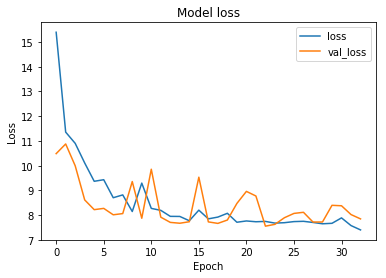

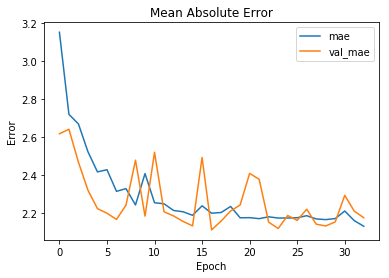

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='mae')
plt.plot(history.history['val_mean_absolute_error'], label='val_mae')
plt.legend()
plt.title('Mean Absolute Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.plot()



In [13]:
model.load_weights('model.ckpt.hdf5')

In [17]:
from tqdm import tqdm_notebook

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={'time_to_failure': np.float32})

for seg_id in tqdm_notebook(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    X = feature_gen(seg['acoustic_data'].values, strides=Generator.STRIDES, k=Generator.NDIMS)
    y = model.predict(X[np.newaxis, :])
    submission.loc[seg_id]['time_to_failure'] = y
submission.to_csv('submission.csv')

KeyboardInterrupt: 